[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fobos123deimos/fast-wave/blob/main/examples/speed_tests_numba_and_cython.ipynb)



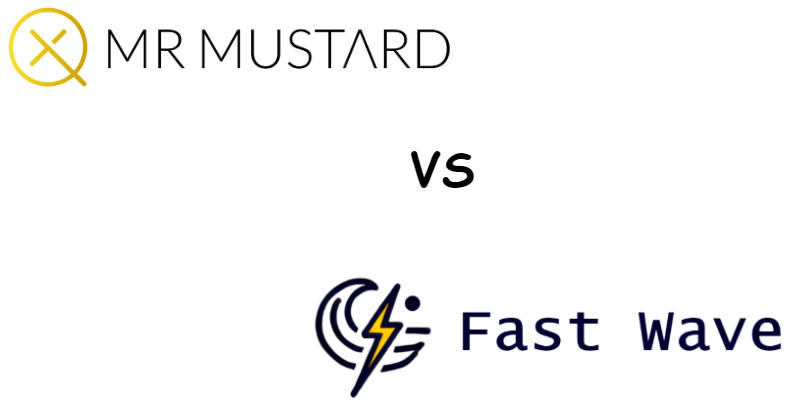

### Understanding Mr Mustard's strategy 🤔
---

The [Mr Mustard](https://mrmustard.readthedocs.io/en/stable/index.html) is a Python library developed by the Canadian photonic quantum computing company [Xanadu](https://www.xanadu.ai/), focused on simulating continuous quantum computing based on Gaussian states using mathematical structures such as matrices and tensors. Additionally, the library can be used for wave function calculations, optimizations, quantum states, and time evolution processes.

Mr Mustard contains a submodule named [fock](https://mrmustard.readthedocs.io/en/stable/_modules/mrmustard/physics/fock.html#oscillator_eigenstate) within the physics module for simulating quantum states in **Fock space** (a representation in quantum mechanics used to describe systems with the discrete particle number basis). In this submodule, there is a function named [oscillator_eigenstate](https://mrmustard.readthedocs.io/en/stable/code/api/mrmustard.physics.fock.oscillator_eigenstate.html), which is used to generate quantum states associated with vibrational modes, such as energy eigenfunctions of a quantum harmonic oscillator, within **Fock space**.


This package leverages [Numba](https://numba.pydata.org/), a **JIT** compiler, to accelerate NumPy code by translating it into efficient machine code. However, there's a one-time compilation overhead on the initial execution.Additionally, Mr Mustard uses **LRU (Least Recently Used)** cache management through the *@lru_cache* decorator from Python's [functools](https://docs.python.org/3/library/functools.html) library. This allows previous results to be stored, avoiding recalculation and thereby increasing the execution efficiency of the function. In this notebook, we provide an honest comparison of execution time between the fixed-precision modules (Numba and [Cython](https://cython.org/)) from the Fast Wave package, which uses another strategy, and the strategy used by the **oscillator_eigenstate** function in the fock submodule of the Mr. Mustard package. It is important to note that the Cython modules do not have compilation overhead like those that use Numba, as they are already compiled files **.pyd** for Windows and **.so** for Linux.

---
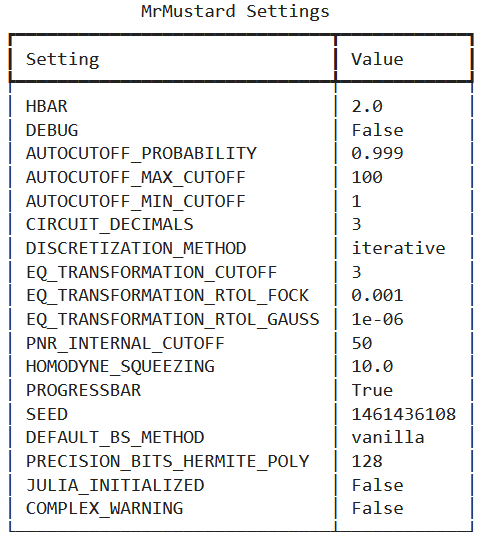
---

In [ ]:
#@title Installation
!pip install fast_wave
!pip install mrmustard --no-deps

In [2]:
#@title Imports and Definitions
import time
import numpy as np
import plotly.graph_objects as go


import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from mrmustard.physics.fock import oscillator_eigenstate

import fast_wave.wavefunction_cython as wc
import fast_wave.wavefunction_numba as wn
from fast_wave.caching import int_array_cache_Cython, int_array_cache_Numba_single_fock, int_array_cache_Numba_multiple_fock

from functools import lru_cache, wraps

HBAR = 2.0
h_bar_12 = np.sqrt(HBAR)
h_bar_14 = np.sqrt(h_bar_12)

oscillator_eigenstate_no_cache = oscillator_eigenstate.__wrapped__

%matplotlib inline

Functionality Test Passed: True


## Performance Comparison: Mr Mustard vs. Fast Wave for Single Fock & Single Position Wavefunctions
---
$$$$
**Explanation:** This analysis evaluates the computational efficiency of three approaches — Mr Mustard, Fast Wave (Numba), and Fast Wave (Cython)—for calculating the squared amplitude $|\psi_n(x)|^2$ of a Single Fock & Single Position Wavefunction $\psi_n(x)$. The Single Fock & Single Position wavefunction, $\psi_{i}(x)$, maps a scalar input $x$ to a scalar output. Execution times for each aproach are plotted to facilitate comparison.
$$$$

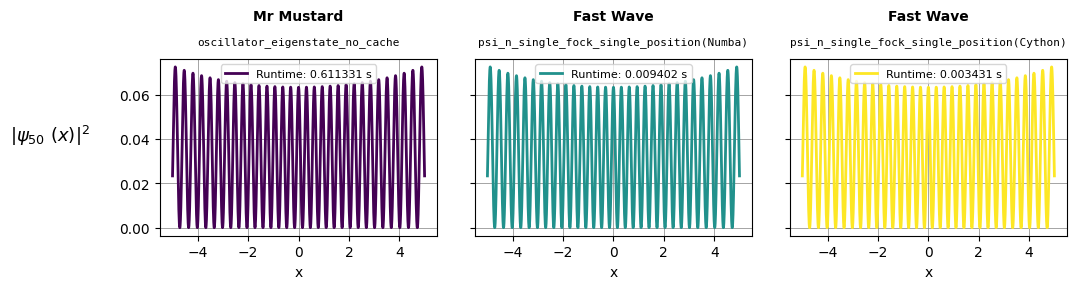

In [11]:
n = 50 #@param
x_max = 5.0 #@param
x_min = -5.0 #@param
number_of_points = 5000 #@param
use_normalized_hermite_coefficients_matrix_Numba = True #@param

x_values = np.linspace(x_min, x_max, number_of_points)

start_time = time.time()
y_Psi_n_x_Fast_Wave_Cython = [ abs(wc.psi_n_single_fock_single_position(n,x))**2 for x in x_values]
Fast_Wave_Cython_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Fast_Wave_Numba = [ abs(wn.psi_n_single_fock_single_position(n,x,CS_matrix = use_normalized_hermite_coefficients_matrix_Numba))**2 for x in x_values]
Fast_Wave_Numba_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Mr_Mustard = [abs((oscillator_eigenstate_no_cache([x*h_bar_12],n+1)*h_bar_14)[-1][0])**2 for x in x_values]
Mr_Mustard_time = time.time() - start_time


plots = [y_Psi_n_x_Mr_Mustard, y_Psi_n_x_Fast_Wave_Numba, y_Psi_n_x_Fast_Wave_Cython]
titles = ["Mr Mustard", "Fast Wave", "Fast Wave"]
subtitles = ["oscillator_eigenstate_no_cache", "psi_n_single_fock_single_position(Numba)",
             "psi_n_single_fock_single_position(Cython)"]
times = [Mr_Mustard_time, Fast_Wave_Numba_time, Fast_Wave_Cython_time]

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].set_ylabel('$|\psi_{%s} \ (x)|^{2}$'%n, fontsize = 13, rotation = 0,  labelpad = 50)
colors = plt.cm.viridis(np.linspace(0, 1, 3))

for i in range(len(plots)):
    axs[i].plot(x_values, plots[i], linewidth=2, color = colors[i], label=f"Runtime: {times[i]:.6f} s",)
    axs[i].grid(color='gray', linestyle='-', linewidth=0.5)
    axs[i].set_xlabel('x')

    axs[i].set_title(f"{titles[i]}", fontsize=10, fontweight='bold', pad=28)
    axs[i].text(0.5, 1.10, f"{subtitles[i]}", fontsize=8, fontfamily='monospace', ha='center', va='center', transform=axs[i].transAxes)
    axs[i].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

## Performance Comparison: Mr Mustard vs. Fast Wave for Single Fock & Multiple Position Wavefunctions
---
$$$$
**Explanation:** This analysis evaluates the computational efficiency of three approaches—Mr Mustard, Fast Wave (Numba), and Fast Wave (Cython) — for calculating the squared amplitude $|\psi_n(X_{m})|^2$ of a Single Fock & Multiple Position Wavefunction $\psi_n(X_{m})$. The Single Fock & Multiple Position wavefunction, $\psi_{i}(X_{m})$, maps an array of position inputs $X_{m}$ to an array of corresponding outputs, this implies that:

$$$$
$$\psi_{i}(X_{m}) = [\psi_{i}(x_{1}), \psi_{i}(x_{2}), ..., \psi_{i}(x_{m})]_{\, m}$$
$$$$

Execution times for each aproach method are plotted to facilitate comparison.
$$$$

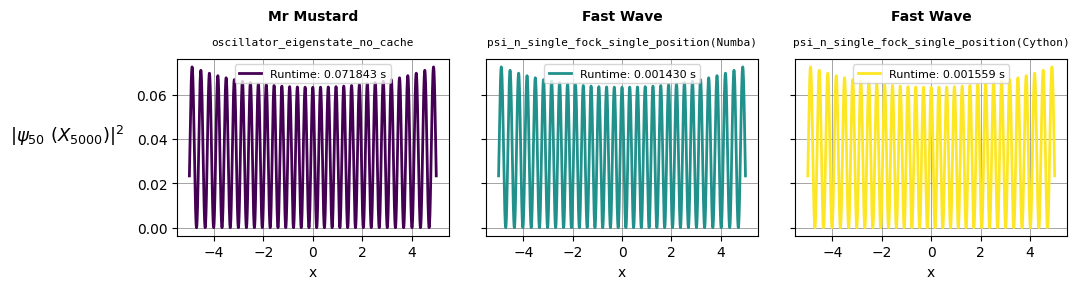

In [12]:
n = 50 #@param
x_max = 5.0 #@param
x_min = -5.0 #@param
number_of_points = 5000 #@param
use_normalized_hermite_coefficients_matrix_Numba = True #@param

x_values = np.linspace(x_min, x_max, number_of_points)

start_time = time.time()
y_Psi_n_x_Fast_Wave_Cython = (abs(wc.psi_n_single_fock_multiple_position(n,x_values))**2).tolist()
Fast_Wave_Cython_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Fast_Wave_Numba = (abs(wn.psi_n_single_fock_multiple_position(n,x_values, CS_matrix = use_normalized_hermite_coefficients_matrix_Numba))**2).tolist()
Fast_Wave_Numba_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Mr_Mustard = (abs((oscillator_eigenstate_no_cache(x_values*h_bar_12,n+1)*h_bar_14)[-1])**2).tolist()
Mr_Mustard_time = time.time() - start_time


plots = [y_Psi_n_x_Mr_Mustard, y_Psi_n_x_Fast_Wave_Numba, y_Psi_n_x_Fast_Wave_Cython]
titles = ["Mr Mustard", "Fast Wave", "Fast Wave"]
subtitles = ["oscillator_eigenstate_no_cache", "psi_n_single_fock_single_position(Numba)", "psi_n_single_fock_single_position(Cython)"]
times = [Mr_Mustard_time, Fast_Wave_Numba_time, Fast_Wave_Cython_time]

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].set_ylabel('$|\psi_{%s} \ (X_{%s})|^{2}$'%(n,number_of_points), fontsize = 13, rotation = 0,  labelpad = 50)
colors = plt.cm.viridis(np.linspace(0, 1, 3))

for i in range(len(plots)):
    axs[i].plot(x_values, plots[i], linewidth=2, color = colors[i], label=f"Runtime: {times[i]:.6f} s",)
    axs[i].grid(color='gray', linestyle='-', linewidth=0.5)
    axs[i].set_xlabel('x')

    axs[i].set_title(f"{titles[i]}", fontsize=10, fontweight='bold', pad=28)
    axs[i].text(0.5, 1.10, f"{subtitles[i]}", fontsize=8, fontfamily='monospace', ha='center', va='center', transform=axs[i].transAxes)
    axs[i].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

## Performance Comparison: Mr Mustard vs. Fast Wave for Multiple Fock & Multiple Position Wavefunctions
---
$$$$
**Explanation:** This analysis evaluates the computational efficiency of three approaches — Mr Mustard, Fast Wave (Numba), and Fast Wave (Cython) — for calculating the squared amplitude $|\psi_{\,0\rightarrow n}\big(X_{m}\big)|^2$ of a Multiple Fock & Multiple Position Wavefunction $\psi_{\,0\rightarrow n}\big(X_{m}\big)$. The Multiple Fock & Multiple Position Wavefunction, $\psi_{\,0\rightarrow i}\big(X_{m}\big)$, maps an array of position inputs $X_{m}$ to an matrix of corresponding outputs, this implies that:

$$$$
$$ \psi_{\,0\rightarrow i}\big(X_{m}\big) = \begin{bmatrix}
  \psi_{0}(x_{1}) & \cdots & \psi_{0}(x_{m})  \\
  \vdots & \ddots & \vdots \\
  \psi_{i}(x_{1}) & \cdots & \psi_{i}(x_{m}) \\
  \end{bmatrix}_{(i+1) \, \times \, m}$$
$$$$
Execution times for each aproach are plotted to facilitate comparison.
$$$$

In [15]:
n = 5 #@param
x_max = 5.0 #@param
x_min = -5.0 #@param
number_of_points = 50 #@param

x_values = np.linspace(x_min, x_max, number_of_points)

start_time = time.time()
y_Psi_n_x_Fast_Wave_Cython = (abs(wc.psi_n_multiple_fock_multiple_position(n,x_values))**2).tolist()
Fast_Wave_Cython_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Fast_Wave_Numba = (abs(wn.psi_n_multiple_fock_multiple_position(n,x_values))**2).tolist()
Fast_Wave_Numba_time = time.time() - start_time

start_time = time.time()
y_Psi_n_x_Mr_Mustard = (abs((oscillator_eigenstate_no_cache(x_values*h_bar_12,n+1)*h_bar_14))**2).tolist()
Mr_Mustard_time = time.time() - start_time


approaches = ["Mr Mustard", "Fast Wave (Numba)", "Fast Wave (Cython)"]
execution_times = [Mr_Mustard_time, Fast_Wave_Numba_time, Fast_Wave_Cython_time]

fig = go.Figure(data=[go.Bar(
    x=approaches,
    y=execution_times,
    marker=dict(
        color=['#800080', '#008000', '#FFFF00'],
    )
)])

fig.update_layout(
    title="Performance Comparison",
    xaxis_title="Approach",
    yaxis_title="Runtime (s)",
    bargap=0.6,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(255,255,255,0.8)',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
    width=800,
    height=400
)